This practice comes from [#WOW2023 Week 19: Can you create a jitterfly chart? TC23 Live Edition](https://workout-wednesday.com/2023w19tab/), which creates a Jitterfly chart (Jitter & Butterfly). The main point is to add some jitter to the data in the scatter plot.

In [1]:
import pandas as pd
import numpy as np

In [2]:
file_path = '../data/central_trend_2017_base.xlsx'
genders = ['Males', 'Females']
primary_year = '2023'
secondary_year = '2011'

In [3]:
data = pd.read_excel(file_path, sheet_name=None)

In [6]:
data_selected = {}
for gender in genders:
    # Cut the age into discrete intervals
    bins = np.arange(0, data[f'Population - {gender}']['age'].max()+1, 10)
    bins[0] = -1
    labels = ['<=10' if age<10 else ('80+' if age>=80 else f'{age+1}-{age+10}') 
              for age in bins[:-1]]
    df = data[f'Population - {gender}']
    df['age_level'] = pd.cut(df['age'], bins=bins, labels=labels)
    df.columns = df.columns.astype('str')
    # Remove the items for London, which is the total population and duplicate.
    data_selected[gender] = df.query('district != "London"').groupby(['age_level', 'district']).sum(numeric_only=True)
    data_selected[f'{gender}_avg']  =data_selected[gender].groupby('age_level').mean(numeric_only=True)

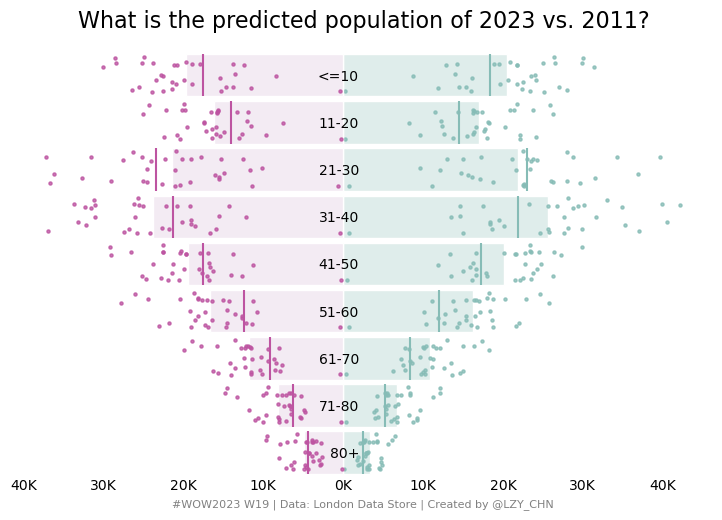

In [8]:
# First create the jitterfly chart by matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

fig, ax = plt.subplots(figsize=(9, 6))

colors = {'Males': ['#DFEDEB', '#86BCB6'],
          'Females': ['#F3EBF3', '#BD54A1']}

bars = {}
points = {}

for gender in genders:
    # Add bar chart
    ys = data_selected[f'{gender}_avg'].index
    xs = data_selected[f'{gender}_avg'][primary_year]
    if gender == 'Females':
        xs = -xs
    bars[gender] = ax.barh(y=ys, width=xs, height=0.9,
                           color=colors[gender][0], ec='white')

    # Add some jitter to the scatter chart
    offset = 0.9
    bbox = bars[gender].patches[0].get_bbox()
    unique_districts = data_selected[f'{gender}'].reset_index()['district'].unique()
    jitter = pd.DataFrame({'district': unique_districts,
                           'jitter': np.random.default_rng(123).uniform(
                               offset*bbox.ymin, offset*bbox.ymax, len(unique_districts))})
    
    df = data_selected[f'{gender}'].reset_index().merge(jitter, on='district')
    age_level = df['age_level'].unique()
    age_pos = pd.DataFrame({'age_level': age_level,
                            'age_pos': np.arange(0, len(age_level))})
    df = df.merge(age_pos, on='age_level')
    xs = df[primary_year]
    ys = df['age_pos'] + df['jitter']
    if gender == 'Females':
        xs = -xs
    points[gender] = ax.scatter(x=xs, y=ys, s=5, c=colors[gender][1], alpha=0.8)
    
    # Add average population for the secondary year
    ymin, ymax = zip(*[(p.get_bbox().ymin, p.get_bbox().ymax) for p in bars[gender].patches])
    xs = data_selected[f'{gender}_avg'][secondary_year]
    if gender == 'Females':
        xs = -xs
    ax.vlines(xs, ymin, ymax, colors=colors[gender][1])
    
ax.invert_yaxis()
ax.spines['left'].set_position(('data', 0))
ax.spines[:].set_visible(False)
ax.tick_params(left=False, pad=-15, bottom=False)
ax.xaxis.set_major_formatter(lambda x, pos: f'{abs(x)/1000:.0f}K')

ax.annotate('What is the predicted population of 2023 vs. 2011?', 
            xy=(0.5, 1), xycoords='axes fraction',
            ha='center', va='bottom', fontsize=16)
ax.annotate('#WOW2023 W19 | Data: London Data Store | Created by @LZY_CHN',
            xy=(0.5, 0), xytext=(0, -3), xycoords='axes fraction', textcoords='offset points',
            ha='center', va='top', fontsize=8, color='gray');

In [62]:
# Another try with seaborn
import seaborn.objects as so

data_so_males = data_selected['Males'].copy()
data_so_females = data_selected['Females'].copy()
data_so_males['gender'] = 'Males'
data_so_females['gender'] = 'Females'
data_so_females[primary_year] = -data_so_females[primary_year]
data_so_females[secondary_year] = -data_so_females[secondary_year]
data_joined = pd.concat([data_so_males,data_so_females]).reset_index()

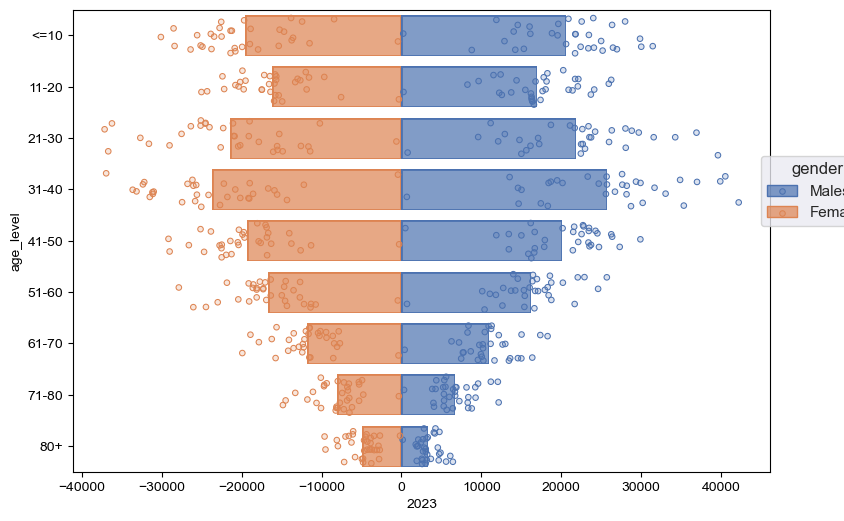

In [79]:
fig, ax = plt.subplots(figsize=(9, 6))

p = so.Plot(data_joined, x=primary_year, y='age_level', color='gender').add(
    so.Bar(), so.Agg()).add(
    so.Dots(), so.Jitter(y=0.7))

p.on(ax).show()